# Import packages

In [1]:
# Import packages

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.stats import ttest_ind, ranksums
from statsmodels.stats.multitest import multipletests

from adjustText import adjust_text


/var/folders/xq/p2w9mvg10_qcg_6l976ph_t80000gn/T/ipykernel_21442/1545426505.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Clean data

In [2]:
# Import and clean data set

df = pd.read_excel('datafile_fullynormalized_collapsed.xlsx', header = 0, index_col = 2)

df.index.name = None
df.columns.name = "Gene"

# Drop columns by name
df.drop(['Protein', 'Molecule', 'UniProt'], axis=1, inplace=True)

df = df.dropna()

# z-score normalize by row and column
df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# drop the outliers: 2.5th and 97.5th percentile
df = df.apply(lambda x: np.clip(x, x.quantile(0.025), x.quantile(0.975)), axis=1)

# Copy header as a new row
df.loc['Participant'] = [p[0] for p in df.columns]

# Replace C with "Control"
# Replace P with "Patient"
df.loc['Participant'] = df.loc['Participant'].replace('C', 'Control')
df.loc['Participant'] = df.loc['Participant'].replace('P', 'Patient')

# transpose the original df for future use (volcano plot)
df_transposed = df.T
df_transposed.columns.name = None

# Check distribution for normalization

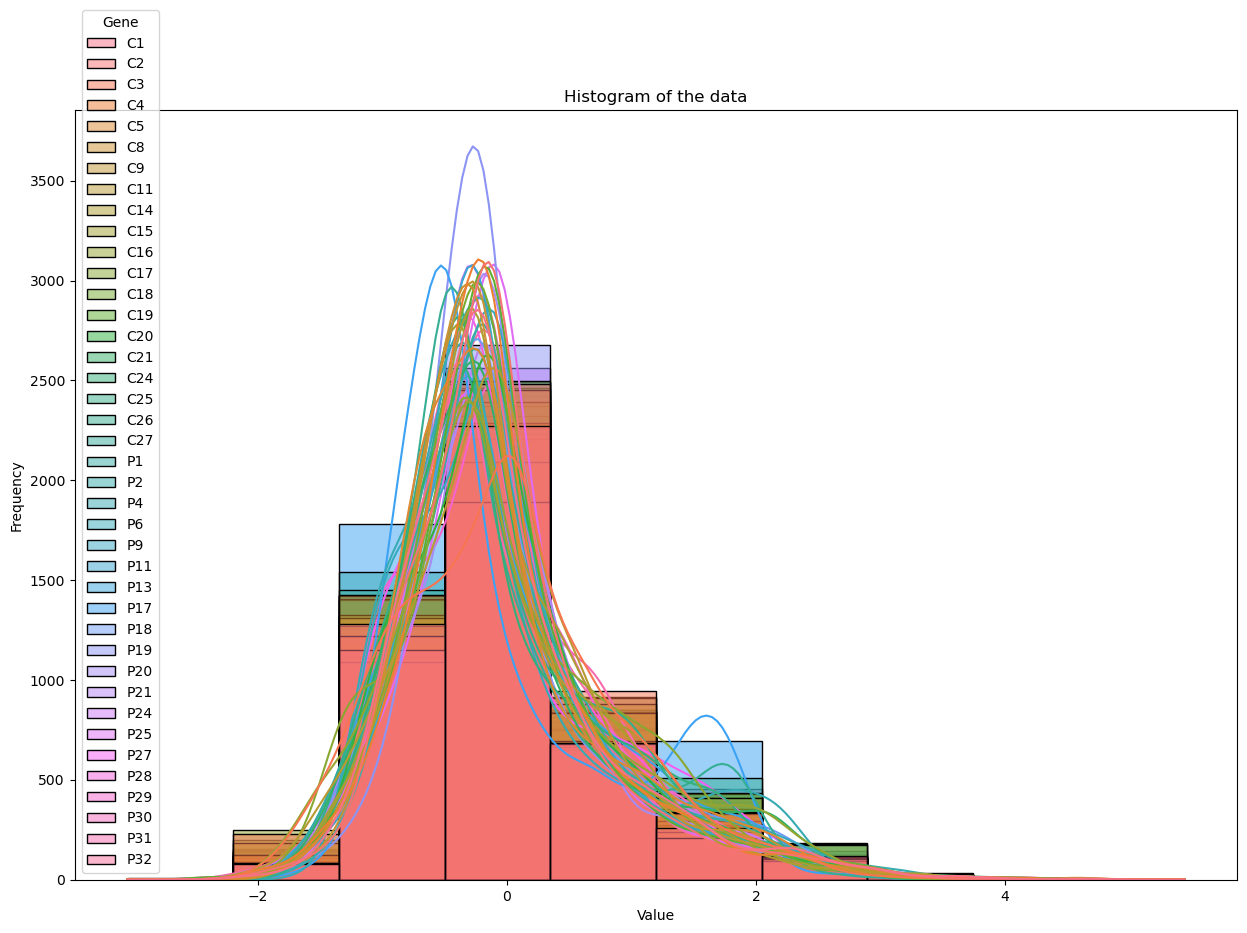

In [3]:
# histo of df
df_nolabels = df.drop('Participant')

# Create a histogram of the data
plt.figure(figsize=(15, 10))
sns.histplot(df_nolabels, bins=10, kde=True)
plt.title('Histogram of the data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Wilcoxon rank-sum test (replica)

In [4]:
# do a Wilcoxon rank-sum test for each gene, comparing the control and patient groups
p_values = []
for gene in df.index:
    patient = df.loc[gene][df.loc['Participant'] == 'Patient']
    control = df.loc[gene][df.loc['Participant'] == 'Control']
    p_values.append(ranksums(patient, control).pvalue)

pq_values_df = pd.DataFrame(p_values, index=df.index, columns=['p_value'])
pq_values_df = pq_values_df.sort_values('p_value')
pq_values_df = pq_values_df.drop('Participant')

quantity_significant = len(pq_values_df[pq_values_df['p_value'] < 0.05])

print(f'{quantity_significant} genes are significantly different between the control and patient groups')

pq_values_df

334 genes are significantly different between the control and patient groups


,p_value
RNASE1,0.000039
EFNA4,0.000062
AIF1L,0.000062
CRABP2,0.000110
PXDN,0.000122
...,...
KIR3DL1,1.000000
OBP2B,1.000000
PPCDC,1.000000
PCNA,1.000000


In [5]:
# correct using the Benjamini-Hochberg procedure
q_values = multipletests(pq_values_df['p_value'], method='fdr_bh', alpha=0.05)[1]
pq_values_df['q_value'] = q_values

pq_values_df

,p_value,q_value
RNASE1,0.000039,0.098543
EFNA4,0.000062,0.098543
AIF1L,0.000062,0.098543
CRABP2,0.000110,0.115987
PXDN,0.000122,0.115987
...,...,...
KIR3DL1,1.000000,1.000000
OBP2B,1.000000,1.000000
PPCDC,1.000000,1.000000
PCNA,1.000000,1.000000


In [6]:
p_val_threshold = 0.05
q_val_threshold = 0.15

In [7]:
# trim pq_values_df to only include genes under the p-value threshold
pq_values_df_trimmed = pq_values_df[pq_values_df['p_value'] < p_val_threshold]

# trim pq_values_df to only include genes under the q-value threshold
pq_values_df_trimmed = pq_values_df_trimmed[pq_values_df_trimmed['q_value'] < q_val_threshold]

pq_values_df_trimmed

,p_value,q_value
RNASE1,0.000039,0.098543
EFNA4,0.000062,0.098543
AIF1L,0.000062,0.098543
CRABP2,0.000110,0.115987
PXDN,0.000122,0.115987
IL18BP,0.000189,0.136976
ROR1,0.000211,0.136976
MXRA7,0.000234,0.136976
CFTR,0.000260,0.136976
PPIC,0.000289,0.136976


In [8]:
# two new columns: mean of the control group and mean of the patient group per gene
df_means = pd.DataFrame(index=pq_values_df_trimmed.index, columns=['Control', 'Patient'])

for gene in pq_values_df_trimmed.index:
    df_means.loc[gene, 'Control'] = df.loc[gene][df.loc['Participant'] == 'Control'].mean()
    df_means.loc[gene, 'Patient'] = df.loc[gene][df.loc['Participant'] == 'Patient'].mean()

# append to pq_values_df_trimmed
pq_values_df_trimmed = pq_values_df_trimmed.join(df_means)

pq_values_df_trimmed

,p_value,q_value,Control,Patient
RNASE1,0.000039,0.098543,-0.492282,0.513737
EFNA4,0.000062,0.098543,-0.561469,0.613911
AIF1L,0.000062,0.098543,-0.586594,0.658652
CRABP2,0.000110,0.115987,-0.530425,0.625908
PXDN,0.000122,0.115987,-0.52374,0.514419
IL18BP,0.000189,0.136976,-0.536454,0.55006
ROR1,0.000211,0.136976,-0.520883,0.604693
MXRA7,0.000234,0.136976,-0.397037,0.254919
CFTR,0.000260,0.136976,0.446304,-0.533764
PPIC,0.000289,0.136976,-0.50741,0.643511


# Set up for box plot analysis

In [9]:
# in df_transposed, keep only the genes that are in pq_values_df_trimmed and the Participant column
df_t_trimmed = df_transposed[pq_values_df_trimmed.index]
df_t_trimmed = df_t_trimmed = pd.concat([df_t_trimmed, df_transposed[['Participant']]], axis=1)

df_t_trimmed.loc[:, "Sample"] = df_t_trimmed.index
df_long = df_t_trimmed.melt(id_vars = ["Participant", "Sample"])
df_long_rows_to_keep = df_long.iloc[:, 3].notna()
df_long = df_long.loc[df_long_rows_to_keep]

In [10]:
# place CFTR at the very end of the plot
df_long = df_long.sort_values(by='variable', key=lambda x: x=='CFTR')

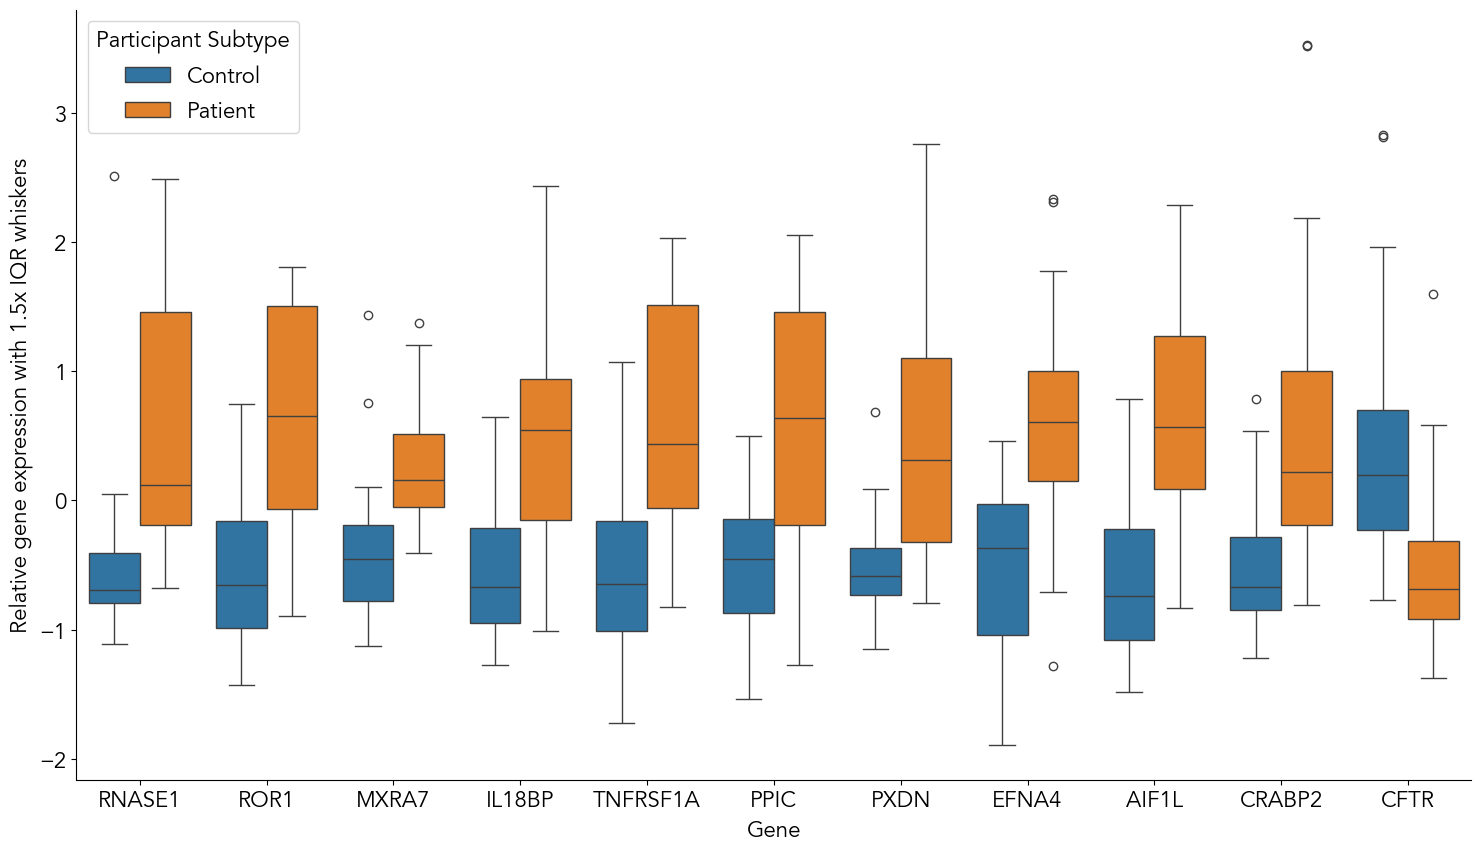

In [27]:
# Set the figure and font size
plt.figure(figsize=(18, 10))
plt.rcParams.update({'font.size': 16, 'font.family': 'sans-serif', 'font.sans-serif': 'Avenir'})

# Create the box plot
sns.boxplot(data=df_long, x="variable", y="value", hue="Participant")

# Set the x-axis label
plt.xlabel("Gene")
plt.ylabel("Relative gene expression with 1.5x IQR whiskers")
plt.legend(title="Participant Subtype")
sns.despine()

# Set up for volcano plot analysis

In [12]:
patient_subset = df.loc[:, df.loc['Participant'] == 'Patient']
patient_subset = patient_subset.drop('Participant')
patient_subset = patient_subset.apply(pd.to_numeric, errors='coerce')

control_subset = df.loc[:, df.loc['Participant'] == 'Control']
control_subset = control_subset.drop('Participant')
control_subset = control_subset.apply(pd.to_numeric, errors='coerce')

z_diff = patient_subset.mean(axis=1) - control_subset.mean(axis=1)

# Volcano plot analysis through Student's t-test

/var/folders/xq/p2w9mvg10_qcg_6l976ph_t80000gn/T/ipykernel_21442/208502373.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = z_diff[patient_subset.index.get_loc(gene)]
/var/folders/xq/p2w9mvg10_qcg_6l976ph_t80000gn/T/ipykernel_21442/208502373.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = z_diff[patient_subset.index.get_loc(gene)]


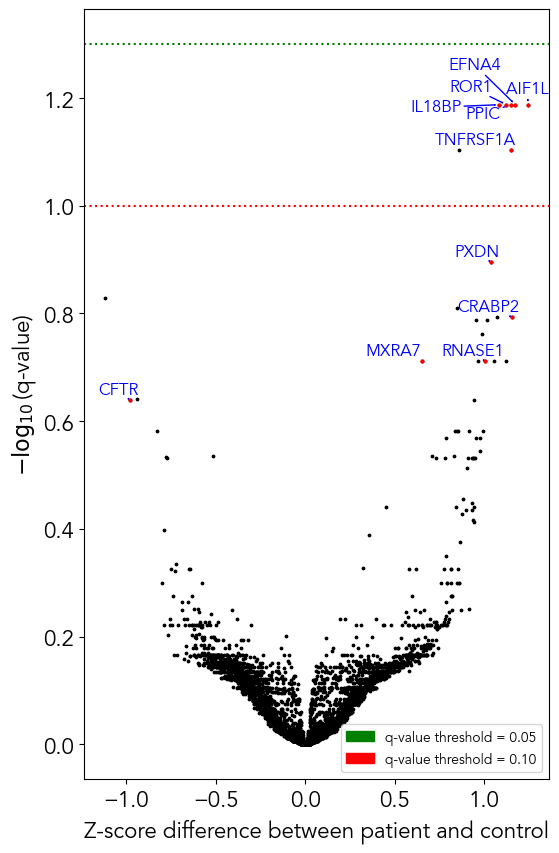

In [14]:
# This is Student's two-tailed, independent, equal variance t-test
t_stats, ttest_p_values = ttest_ind(patient_subset, control_subset, equal_var=True, axis=1)

ttest_q_values = multipletests(ttest_p_values, method='fdr_bh', alpha=0.05)[1]

minus_log10_q_values = -np.log10(ttest_q_values)

# create the plot
plt.figure(figsize=(6, 10))
plt.rcParams.update({'font.size': 16, 'font.family': 'sans-serif', 'font.sans-serif': 'Avenir'})

plt.scatter(z_diff, minus_log10_q_values, color='black', s=3)
plt.xlabel('Z-score difference between patient and control')
plt.ylabel(r'$-\log_{10}$(q-value)')

# add a line at p-value = 0.05 and 0.10

plt.axhline(y=1.3, color='g', linestyle=':')
plt.axhline(y=1.0, color='r', linestyle=':')

# add labels for the lines
green_patch = mpatches.Patch(color='green', label='q-value threshold = 0.05')
red_patch = mpatches.Patch(color='red', label='q-value threshold = 0.10')
plt.legend(handles=[green_patch, red_patch], fontsize=10)

# points of interest
texts = []  # to hold the text objects
points_of_interest = pq_values_df_trimmed.index
for gene in points_of_interest:
    x = z_diff[patient_subset.index.get_loc(gene)]
    y = minus_log10_q_values[patient_subset.index.get_loc(gene)]

    texts.append(plt.text(x, y, gene, ha='right', fontsize=12, color='blue'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='blue'))

# color the points of interest
for gene in points_of_interest:
    x = z_diff[patient_subset.index.get_loc(gene)]
    y = minus_log10_q_values[patient_subset.index.get_loc(gene)]
    plt.scatter(x, y, color='red', s=4)

plt.show()


# Uncorrected p-values volcano plot

/var/folders/xq/p2w9mvg10_qcg_6l976ph_t80000gn/T/ipykernel_21442/1493581355.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = z_diff[patient_subset.index.get_loc(gene)]
/var/folders/xq/p2w9mvg10_qcg_6l976ph_t80000gn/T/ipykernel_21442/1493581355.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = z_diff[patient_subset.index.get_loc(gene)]


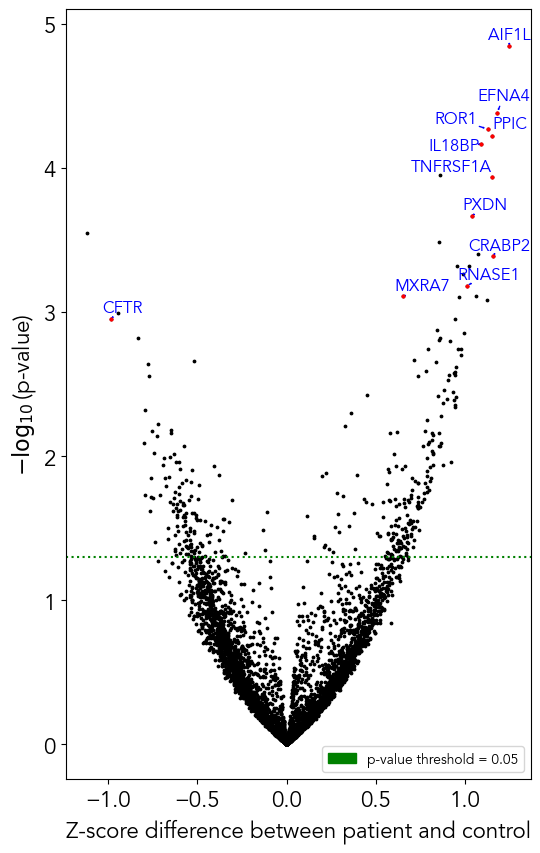

In [15]:
minus_log10_p_values = -np.log10(ttest_p_values)

# create the plot
plt.figure(figsize=(6, 10))
plt.rcParams.update({'font.size': 16, 'font.family': 'sans-serif', 'font.sans-serif': 'Avenir'})

plt.scatter(z_diff, minus_log10_p_values, color='black', s=3)
plt.xlabel('Z-score difference between patient and control')
plt.ylabel(r'$-\log_{10}$(p-value)')

# add a line at p-value = 0.05
plt.axhline(y=1.3, color='g', linestyle=':')

# add label for the line
green_patch = mpatches.Patch(color='green', label='p-value threshold = 0.05')
plt.legend(handles=[green_patch], fontsize=10, loc = 'lower right')

# points of interest
texts = []  # to hold the text objects
points_of_interest = pq_values_df_trimmed.index
for gene in points_of_interest:
    x = z_diff[patient_subset.index.get_loc(gene)]
    y = minus_log10_p_values[patient_subset.index.get_loc(gene)]

    texts.append(plt.text(x, y, gene, ha='right', fontsize=12, color='blue'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='blue'))

# color the points of interest
for gene in points_of_interest:
    x = z_diff[patient_subset.index.get_loc(gene)]
    y = minus_log10_p_values[patient_subset.index.get_loc(gene)]
    plt.scatter(x, y, color='red', s=4)

plt.show()

# Correlation analysis

In [16]:
# We first find the gene-gene interaction within each cohort
# We will use the Pearson correlation coefficient to find the gene-gene interaction

patient_subset_t = patient_subset.T
corr_patient = patient_subset_t.corr()

control_subset_t = control_subset.T
corr_control = control_subset_t.corr()

In [17]:
# We then subtracted the correlation value of ME/CFS patients from controls
corr_diff = corr_patient - corr_control

# Sort the output to find the most contrasting correlations between cohorts
corr_diff_sorted = corr_diff.unstack().sort_values(ascending=False)

# Select for ones that are above 1 and below -1
corr_diff_subset = corr_diff_sorted[(corr_diff_sorted > 1) | (corr_diff_sorted < -1)]

# Remove the duplicates
corr_diff_subset = corr_diff_subset.drop_duplicates()

In [18]:
corr_diff_subset

GNAI1     PNOC       1.494819
ARMC10    USO1       1.415599
PNOC      DLX4       1.412425
FGF4      ADI1       1.408308
DHX58     S100Z      1.407207
                       ...   
PNOC      AFP       -1.388343
AOC1      WFDC10B   -1.422906
AFP       AOC1      -1.430310
NRAC      MAP4K1    -1.434323
CYB561D1  KLK15     -1.443425
Length: 17392, dtype: float64

<Figure size 1800x1000 with 0 Axes>

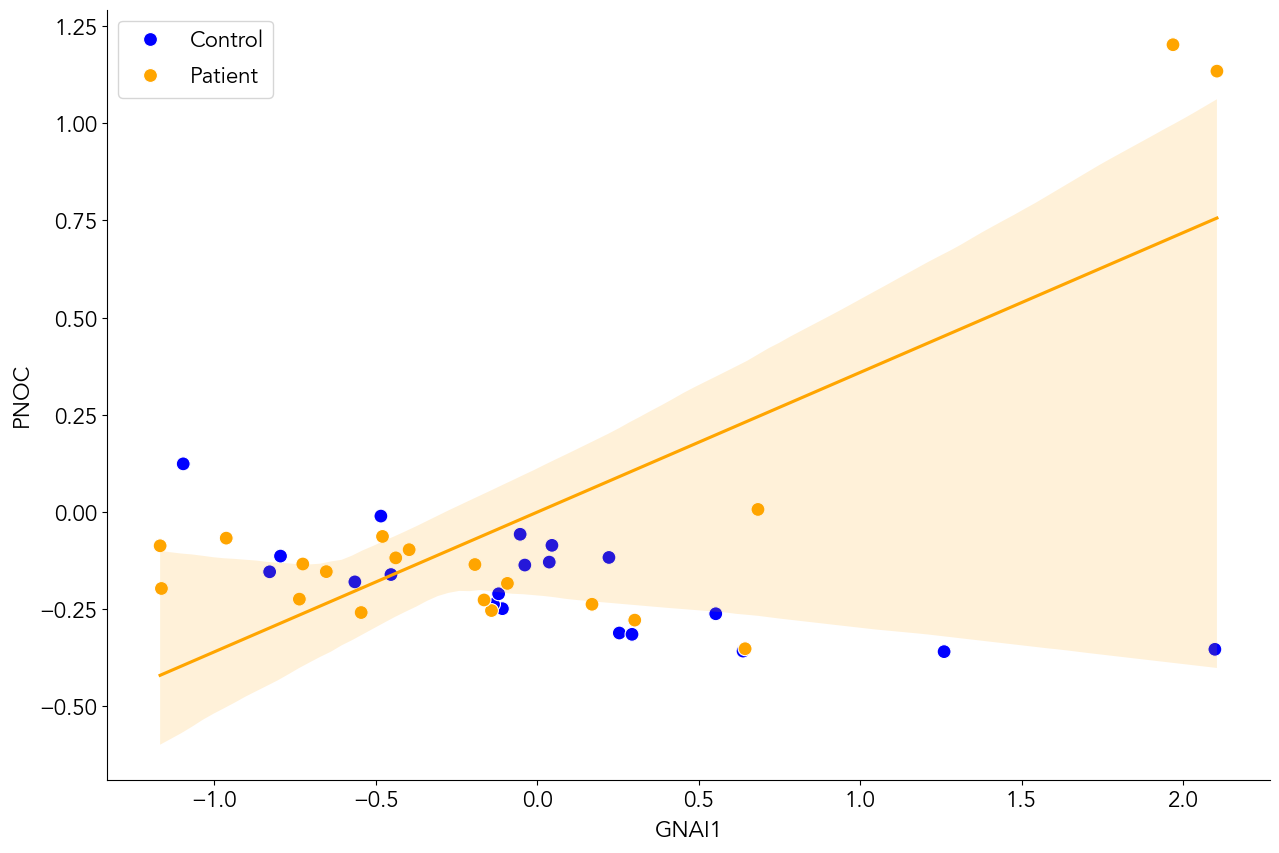

In [22]:
# for the highest correlated gene pair, plot the expression of the two genes in the two cohorts
gene1, gene2 = corr_diff_subset.index[0]

plt.figure(figsize=(18, 10))
plt.rcParams.update({'font.size': 16, 'font.family': 'sans-serif', 'font.sans-serif': 'Avenir'})

df_transposed[gene1] = df_transposed[gene1].astype('float64')
df_transposed[gene2] = df_transposed[gene2].astype('float64')

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 16, 'font.family': 'sans-serif', 'font.sans-serif': 'Avenir'})

sns.scatterplot(data=df_transposed, x=gene1, y=gene2, hue='Participant', palette=['blue', 'orange'], s=100)
sns.regplot(x=patient_subset.loc[gene1], y=patient_subset.loc[gene2], color='orange', scatter=False, ci=95)

sns.despine()
plt.xlabel(gene1)
plt.ylabel(gene2)
plt.legend()
plt.show()

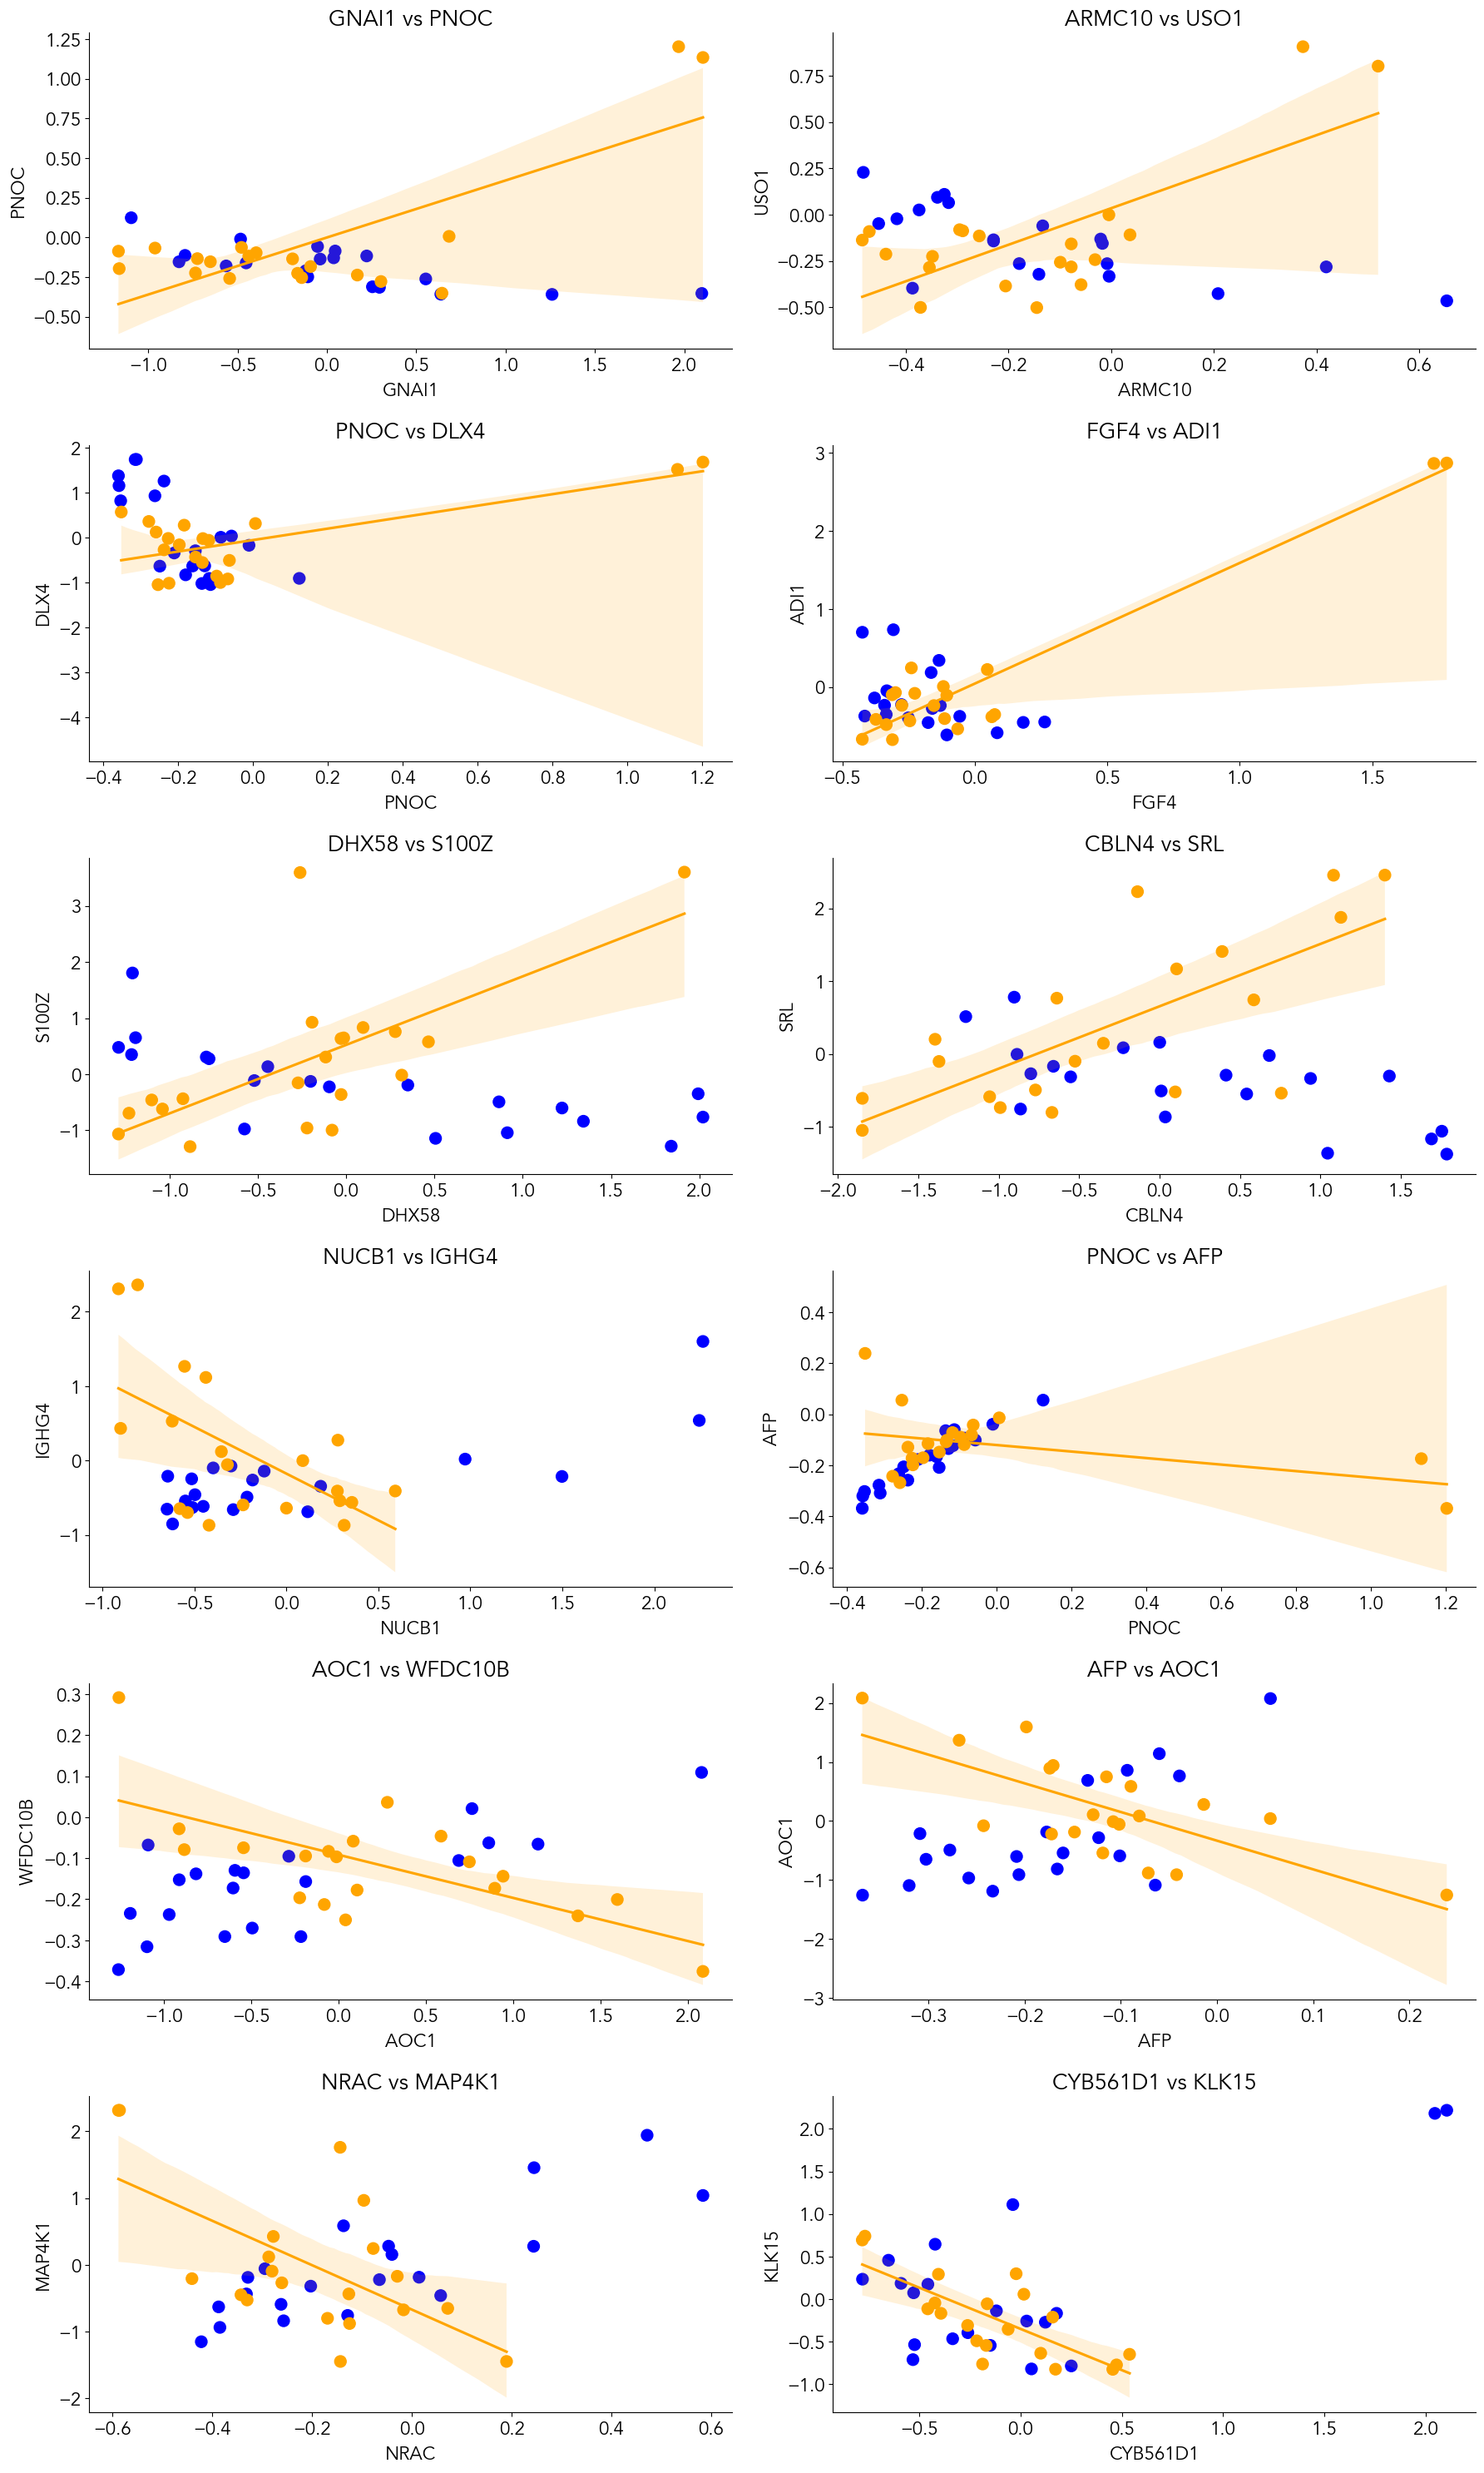

In [20]:
# use C3 on the x-axis. Take the top 6 correlated differences and the bottom 6 correlated differences and plot them in a grid of scatter plots (6x2)

# find the top 6 and bottom 6 correlated differences
corr_diff_subset_top = corr_diff_subset[0:6]
corr_diff_subset_bottom = corr_diff_subset[-6:]

# create the plot
plt.figure(figsize=(18, 30))
plt.rcParams.update({'font.size': 16, 'font.family': 'sans-serif', 'font.sans-serif': 'Avenir'})

for i, (gene1, gene2) in enumerate(corr_diff_subset_top.index):
    plt.subplot(6, 2, i + 1)
    plt.scatter(df_transposed[gene1], df_transposed[gene2], c=df_transposed['Participant'].map({'Control': 'blue', 'Patient': 'orange'}), s=100)
    sns.regplot(x=patient_subset.loc[gene1], y=patient_subset.loc[gene2], color='orange', scatter=False, ci=95)
    plt.title(f'{gene1} vs {gene2}')
    plt.xlabel(gene1)
    plt.ylabel(gene2)
    sns.despine()

for i, (gene1, gene2) in enumerate(corr_diff_subset_bottom.index):
    plt.subplot(6, 2, i + 7)
    plt.scatter(df_transposed[gene1], df_transposed[gene2], c=df_transposed['Participant'].map({'Control': 'blue', 'Patient': 'orange'}), s=100)
    sns.regplot(x=patient_subset.loc[gene1], y=patient_subset.loc[gene2], color='orange', scatter=False, ci=95)
    plt.title(f'{gene1} vs {gene2}')
    plt.xlabel(gene1)
    plt.ylabel(gene2)
    sns.despine()

plt.tight_layout()
plt.show()